In [1]:
import numpy as np
from tqdm import tqdm

@np.vectorize
def count_tries(threshold, N=int(2e6)):
    numbers = np.zeros(N)

    for n in tqdm(range(N)): 
        s=0
        c=0
        while s < threshold:
            s += np.random.uniform(0,1)
            c += 1
        numbers[n] = c
    return(np.average(numbers))

def count_tries_together(thresholds, N = int(5e6)):
    
    averages = np.zeros_like(thresholds)
    tries = np.zeros_like(thresholds)
    m = max(thresholds)
    for n in tqdm(range(N)):
        s=0
        while s < m:
            tries[s < thresholds] += 1
            s += np.random.uniform(0,1)

        averages = (n * averages + tries) / (n+1)
        tries[:] = 0
    return(averages)

def count_overshoots(threshold, N=int(1e7)):
    overshoots = np.zeros(N)

    for n in tqdm(range(N)): 
        s=0
        while s < threshold:
            s += np.random.uniform(0,1)
        overshoots[n] = s - threshold
    return(overshoots)

def measure_penultimate(threshold, N=int(5e5)):
    penultimates = np.zeros(N)

    for n in tqdm(range(N)): 
        s=0
        while s < threshold:
            r = np.random.uniform(0,1)
            s += r
        penultimates[n] = threshold - (s - r)
    return(penultimates)

100%|██████████| 499/499 [00:29<00:00, 17.10it/s]


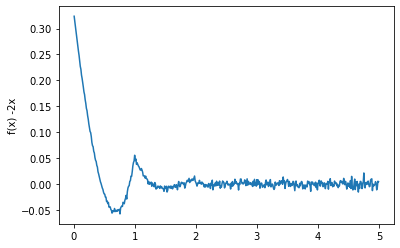

In [8]:
#!/usr/bin/env python3

from random import random
import matplotlib.pyplot as plt

x=0
ATTEMPTS=100_000

r=range(1,500)
xvalues=[]
yvalues=[]

def findValue(x):
    s=0
    n=0
    while(s<x):
        s+=random()
        n+=1
    return n

def findNumber(x):
    s=0
    for i in range(ATTEMPTS):
        s+=findValue(x)
    return s/ATTEMPTS


for x in tqdm(r):
    n = x / 100
    xvalues.append(n)
    yvalues.append(findNumber(n) -2*n)

xs = np.array(xvalues)
ys = np.array(yvalues)

plt.ylabel('f(x) -2x - 2/3')
plt.plot(xs, ys - 2/3)
plt.show()

100%|██████████| 100000/100000 [00:07<00:00, 12721.67it/s]


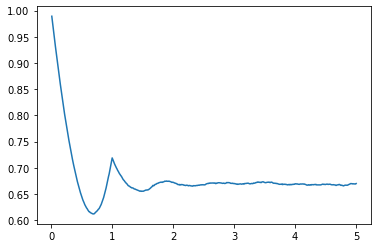

In [11]:
thrs = np.linspace(0.01, 5, num=500)

plt.plot(thrs, count_tries_together(thrs, N=100_000) - 2 * thrs)

# tries = count_tries_together(thrs)

In [17]:
from scipy.special import binom, factorial

def cdf(thr, n):
    s = 0
    for k in range(int(thr) + 1):
        s += (-1)**k * binom(n, k) * (thr-k)**(n)
    return s / factorial(n)

def theoretical(thr, max_n=170):
    s = 0
    for n in range(1, max_n):
        s += n * (cdf(thr, n-1) - cdf(thr, n))
    return(s)


In [18]:
theoreticals = np.array([theoretical(thr) for thr in thrs])

In [50]:
model = lambda x, A, omega, gamma, x0: A * np.exp(-gamma * x) * np.cos(omega * (x - x0))

from scipy.optimize import curve_fit
p0 = [.3, 7.47, 2.1, -1.43]
A, omega, gamma, x0 = p0
# p, pcov = curve_fit(model, thrs, diffs, p0=p0, sigma=np.abs(diffs)**(.6))

# diffs = theoreticals - 2 * thrs - 2/3
# plt.figure(dpi=150)
# plt.plot(thrs,diffs, label='original')
# # plt.plot(thrs, model(thrs, *p), label='p', ls=':')
# plt.plot(thrs, model(thrs, *p0), label='p0', ls=':')
# plt.yscale('symlog', linthreshy=1e-12)
# plt.legend()
# print(p0)

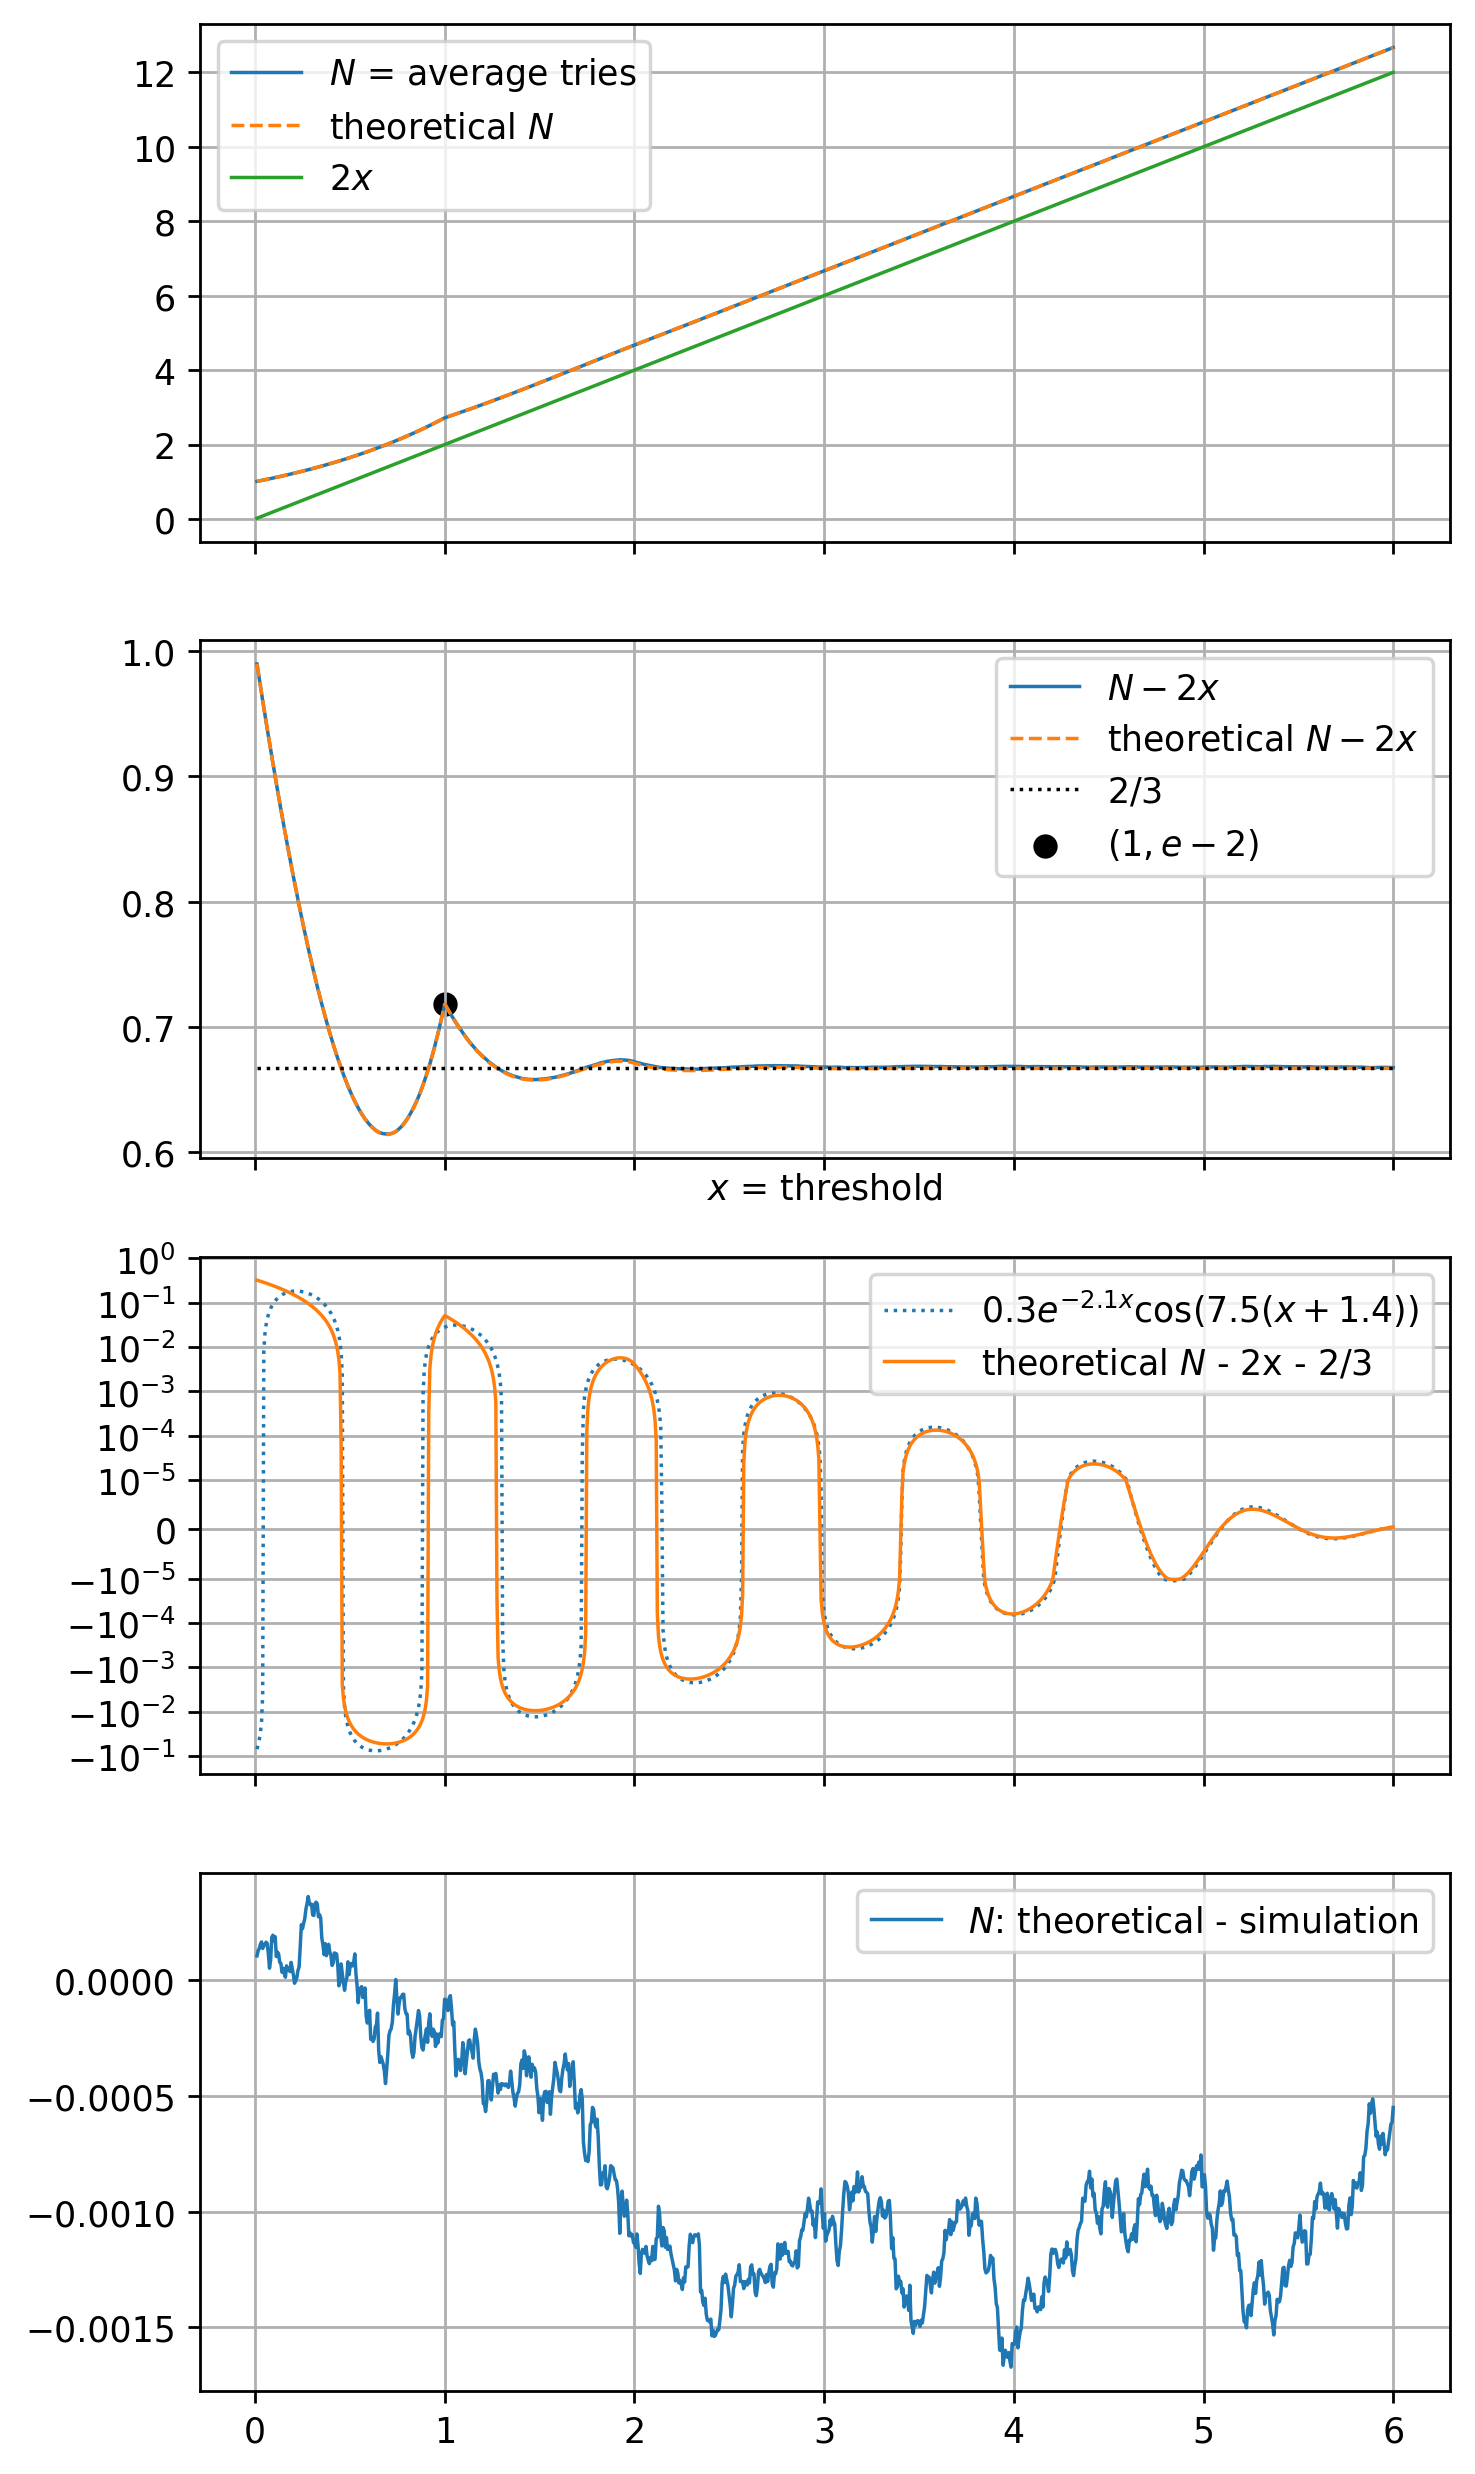

In [52]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(6, 10), dpi=250)
lw = 1
axs[0].plot(thrs, tries, label='$N $ = average tries', lw=lw)
axs[0].plot(thrs, theoreticals, label='theoretical $N$', lw=lw, ls='--')
axs[0].plot(thrs, 2*thrs, label='$2x$', lw=lw)
axs[1].plot(thrs, tries - 2 * thrs, label='$N- 2x$', lw=lw)
axs[1].plot(thrs, theoreticals - 2 * thrs, label='theoretical $ N  - 2x$', lw=lw, ls='--')
axs[1].plot(thrs, 2/3 * np.ones_like(thrs) , lw=lw, c='black', label='$2/3$', ls=':')
axs[1].scatter(1, np.e-2, lw=lw, c='black', label='$(1, e-2)$')
axs[1].set_xlabel('$x$ = threshold')
axs[2].plot(thrs, model(thrs, *p0), label=f'${A:.1f} e^{{- {gamma:.1f} x}} \\cos({omega:.1f} (x + {-x0:.1f}))$', ls=':', lw=lw)
axs[2].plot(thrs, theoreticals - 2 * thrs - 2/3, label='theoretical $N$ - 2x - 2/3', lw=lw)
axs[2].set_yscale('symlog', linthreshy=1e-5)

axs[3].plot(thrs, theoreticals - tries, label='$N$: theoretical - simulation', lw=lw)

[ax.legend() for ax in axs]
[ax.grid(True) for ax in axs]
plt.tight_layout()
plt.savefig('sum_of_uniforms.pdf')
plt.savefig('sum_of_uniforms.png')

In [38]:
%%markdown

The average number of tries $\langle N \rangle$ at a threshold $x$ is given by the expression: 
$$
\begin{align}
N &=
\sum_{n=1}^\infty n 
\left(
\frac{1}{(n-1)!}
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
(x-k)^{n-1}
-
\frac{1}{n!}
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n}{k}
(x-k)^{n}
\right) \\
&= \sum_{n=1}^\infty \frac{n}{n!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\left(
n
\binom{n-1}{k}
(x-k)^{n-1}
-
\binom{n}{k}
(x-k)^{n}
\right)
\right)\\
& = \sum_{n=1}^\infty \frac{1}{(n-1)!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
\left(
n
(x-k)^{n-1}
-
\frac{n}{n-k}
(x-k)^{n}
\right)
\right)\\
&=\sum_{n=1}^\infty \frac{n}{(n-1)!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
(x-k)^{n-1}
\left(
1
-
\frac{x-k}{n-k}
\right)
\right)
\end{align}
$$

which is calculated from the cumulative distribution for the [Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution)


The average number of tries $\langle N \rangle$ at a threshold $x$ is given by the expression: 
$$
\begin{align}
N &=
\sum_{n=1}^\infty n 
\left(
\frac{1}{(n-1)!}
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
(x-k)^{n-1}
-
\frac{1}{n!}
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n}{k}
(x-k)^{n}
\right) \\
&= \sum_{n=1}^\infty \frac{n}{n!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\left(
n
\binom{n-1}{k}
(x-k)^{n-1}
-
\binom{n}{k}
(x-k)^{n}
\right)
\right)\\
& = \sum_{n=1}^\infty \frac{1}{(n-1)!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
\left(
n
(x-k)^{n-1}
-
\frac{n}{n-k}
(x-k)^{n}
\right)
\right)\\
&=\sum_{n=1}^\infty \frac{n}{(n-1)!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
(x-k)^{n-1}
\left(
1
-
\frac{x-k}{n-k}
\right)
\right)
\end{align}
$$

which is calculated from the cumulative distribution for the [Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution)


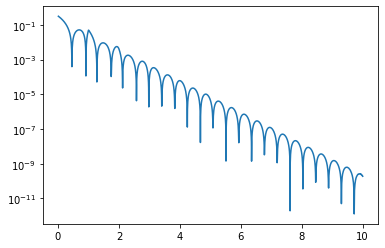

In [3]:
thrs = np.linspace(0.01, 10, num=int(1e4))
theoreticals = np.array([theoretical(thr) for thr in thrs])

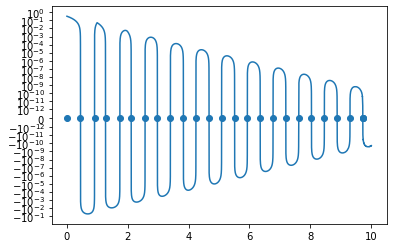

In [4]:
diffs = theoreticals - 2 * thrs - 2/3
ts = []
for i in range(len(diffs)):
    if diffs[i] * diffs[i-1] < 0:
        ts.append(thrs[i])
np.average(np.gradient(ts))
plt.plot(thrs,diffs)
plt.yscale('symlog', linthreshy=1e-12)
plt.scatter(ts, np.zeros_like(ts))

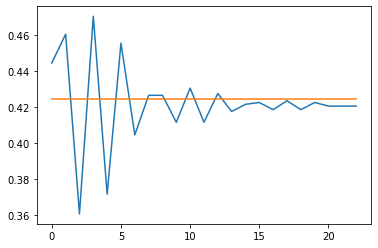

In [7]:
intervals = np.ediff1d(ts) # differenze discrete degli zero-crossings
intervals = intervals[intervals > .1] # quelli più piccoli sono errori numerici
plt.plot(intervals)
plt.plot(np.ones_like(intervals) * (8/3) / (2 * np.pi))

In [159]:
# thrs = thrs[10:]
# diffs = diffs[10:]

[ 0.25914591  7.54999757  2.67848129 -1.42091043]


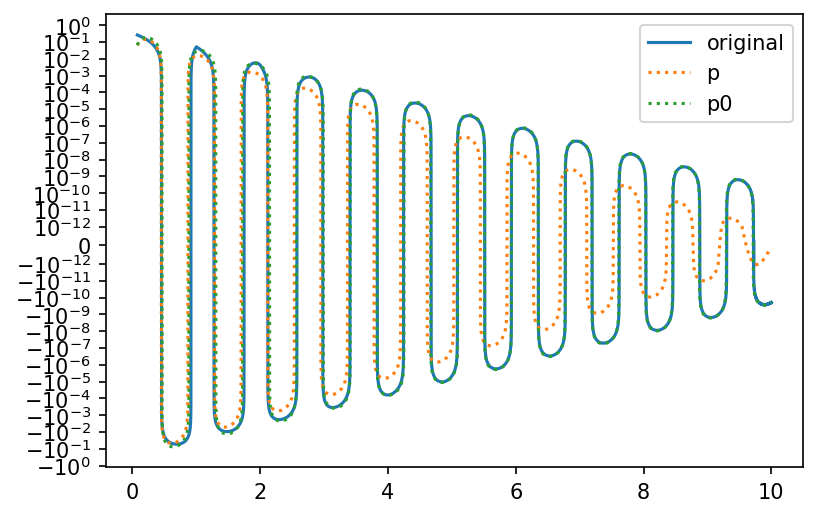

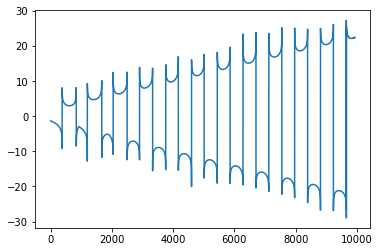

In [178]:
e_diffs = np.sign(diffs) * np.log(np.abs(diffs))
plt.plot(e_diffs)

In [15]:
%%markdown

I am exploring a generalization of the problem discussed e.g.
[here](https://math.stackexchange.com/questions/111314/choose-a-random-number-between-0-and-1-and-record-its-value-keep-doing-it-u), namely:

> What is the expected number $N$ of uniform random variates in $[0,1]$ we need to add in order to surpass a certain threshold $x\in \mathbb{R}^+$?

The question mentioned only discusses the case $x=1$, where $N=e$. 
I have worked out that the number $N(x)$ can be calculated through the cumulative density function of the [Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution), yielding the expression 
$$
\begin{align}
N &=
\sum_{n=1}^\infty n 
\left(
\frac{1}{(n-1)!}
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
(x-k)^{n-1}
-
\frac{1}{n!}
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n}{k}
(x-k)^{n}
\right) \\
&= \sum_{n=1}^\infty \frac{n}{n!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\left(
n
\binom{n-1}{k}
(x-k)^{n-1}
-
\binom{n}{k}
(x-k)^{n}
\right)
\right)\\
& = \sum_{n=1}^\infty \frac{1}{(n-1)!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
\left(
n
(x-k)^{n-1}
-
\frac{n}{n-k}
(x-k)^{n}
\right)
\right)\\
&=\sum_{n=1}^\infty \frac{n}{(n-1)!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
(x-k)^{n-1}
\left(
1
-
\frac{x-k}{n-k}
\right)
\right)\,.
\end{align}
$$

I am including some manipulations I have done for convenience.
This matches simulations quite well, as can be seen in the first and last panels of the figure.
I am simulating the process a few million times, so an error on the order of $10^{-3}$ is expected. 

# [![Graphs][1]][1]

Now, the analytic expression for $N$ does not provide much clarity for me. By graphing the values of $N$ we can see that asymptotically $N \sim 2x + 2/3$ (see the second panel), while the oscillations from the asymptote appear to look like an exponentially suppressed sinusoid far from the origin (see the third panel, which uses a `symlog` scale for the vertical axis --- logarithmic on the positives and negatives, but linear in the region $[-10^{-5}, 10^{-5}]$).
On the other hand, close to the origin the behaviour is different, and at $x=1$ there is a "spike" to reach the value $N=e$. 

So, my question is: what is going on? Is there a clean way to describe all of this analytically? 
Specifically, I am curious about the origin of the parameters of the asymptotes: I can see why the curve would look like $N \sim 2x$, but the 2/3 eludes me.
Also, where do the parameters of the oscillation come from? The periodicity seems rather arbitrary... 

  # [1]: https://i.stack.imgur.com/MP3lQ.png


I am exploring a generalization of the problem discussed e.g.
[here](https://math.stackexchange.com/questions/111314/choose-a-random-number-between-0-and-1-and-record-its-value-keep-doing-it-u), namely:

> What is the expected number $N$ of uniform random variates in $[0,1]$ we need to add in order to surpass a certain threshold $x\in \mathbb{R}^+$?

The question mentioned only discusses the case $x=1$, where $N=e$. 
I have worked out that the number $N(x)$ can be calculated through the cumulative density function of the [Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution), yielding the expression 
$$
\begin{align}
N &=
\sum_{n=1}^\infty n 
\left(
\frac{1}{(n-1)!}
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
(x-k)^{n-1}
-
\frac{1}{n!}
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n}{k}
(x-k)^{n}
\right) \\
&= \sum_{n=1}^\infty \frac{n}{n!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\left(
n
\binom{n-1}{k}
(x-k)^{n-1}
-
\binom{n}{k}
(x-k)^{n}
\right)
\right)\\
& = \sum_{n=1}^\infty \frac{1}{(n-1)!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
\left(
n
(x-k)^{n-1}
-
\frac{n}{n-k}
(x-k)^{n}
\right)
\right)\\
&=\sum_{n=1}^\infty \frac{n}{(n-1)!}
\left(
\sum_{k=0}^{\lfloor x \rfloor}
(-1)^k
\binom{n-1}{k}
(x-k)^{n-1}
\left(
1
-
\frac{x-k}{n-k}
\right)
\right)\,.
\end{align}
$$

I am including some manipulations I have done for convenience.
This matches simulations quite well, as can be seen in the first and last panels of the figure.
I am simulating the process a few million times, so an error on the order of $10^{-3}$ is expected. 

# [![Graphs][1]][1]

Now, the analytic expression for $N$ does not provide much clarity for me. By graphing the values of $N$ we can see that asymptotically $N \sim 2x + 2/3$ (see the second panel), while the oscillations from the asymptote appear to look like an exponentially suppressed sinusoid far from the origin (see the third panel, which uses a `symlog` scale for the vertical axis --- logarithmic on the positives and negatives, but linear in the region $[-10^{-5}, 10^{-5}]$).
On the other hand, close to the origin the behaviour is different, and at $x=1$ there is a "spike" to reach the value $N=e$. 

So, my question is: what is going on? Is there a clean way to describe all of this analytically? 
Specifically, I am curious about the origin of the parameters of the asymptotes: I can see why the curve would look like $N \sim 2x$, but the 2/3 eludes me.
Also, where do the parameters of the oscillation come from? The periodicity seems rather arbitrary... 

  # [1]: https://i.stack.imgur.com/MP3lQ.png


In [57]:
%%markdown

-> see [this](https://math.stackexchange.com/questions/426347/average-number-of-u0-1-random-numbers-to-reach-x)


-> see [this](https://math.stackexchange.com/questions/426347/average-number-of-u0-1-random-numbers-to-reach-x)


In [63]:
%%markdown

The integral equation to solve is:

$$
N(x) = 1 + \int_{x-1}^x N(t) \mathrm{d}t\,,
$$
which implies, setting $N(x) = g(x) + 2x$: 
$$
g(x) = \int_{x-1}^x g(t) \mathrm{d}t\,.
$$

The initial condition to set is $N(x) = 0$ in $[-1, 0]$, so $g(x) = -2x$ there.


The integral equation to solve is:

$$
N(x) = 1 + \int_{x-1}^x N(t) \mathrm{d}t\,,
$$
which implies, setting $N(x) = g(x) + 2x$: 
$$
g(x) = \int_{x-1}^x g(t) \mathrm{d}t\,.
$$

The initial condition to set is $N(x) = 0$ in $[-1, 0]$, so $g(x) = -2x$ there.


In [8]:
initial = lambda x : -2 *x

xs = np.linspace(-1, 6, num=10000)
dx = xs[1] - xs[0]
gs = np.zeros_like(xs)

for i, x in enumerate(xs):
    if x < 0:
        gs[i] = initial(x)
    else:
        cond1 = xs < x
        cond2 = xs > x-1
        gs[i] = np.sum(gs[np.logical_and(xs<x, xs>x-1)]) * dx

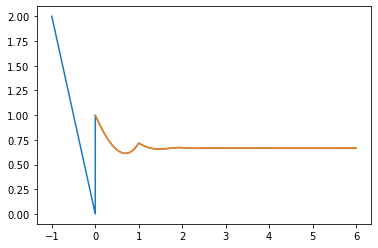

In [20]:
plt.plot(xs, gs)
# plt.xlim(0, 6)
# plt.ylim(.6, 1)
plt.plot(thrs, theoreticals - 2 * thrs)

In [4]:
o = count_overshoots(12)

100%|██████████| 10000000/10000000 [12:26<00:00, 13392.86it/s]


(array([99764., 99150., 98467., 98243., 97866., 97426., 96247., 95800.,
        95597., 95295., 94802., 94113., 93780., 93292., 93107., 91704.,
        91543., 91345., 90506., 90570., 89849., 89386., 88760., 88214.,
        87241., 86821., 86630., 86643., 86055., 85332., 84662., 83999.,
        83982., 83181., 82968., 82471., 82194., 81232., 80719., 80284.,
        79695., 79024., 78698., 78196., 77963., 77002., 76943., 76559.,
        75406., 74845., 74955., 73999., 73566., 73018., 72994., 72436.,
        72314., 71355., 71018., 69918., 69709., 69080., 68461., 68350.,
        67437., 67164., 66681., 66224., 65779., 65241., 64588., 63859.,
        63449., 63605., 62517., 62109., 61560., 60919., 60970., 60504.,
        59738., 59078., 58424., 58403., 57797., 57326., 56866., 56154.,
        56427., 55315., 54758., 54050., 53821., 53603., 52430., 52133.,
        51769., 51243., 50555., 50040., 49717., 49208., 48853., 48080.,
        47606., 47501., 46766., 46155., 45581., 45301., 44430., 

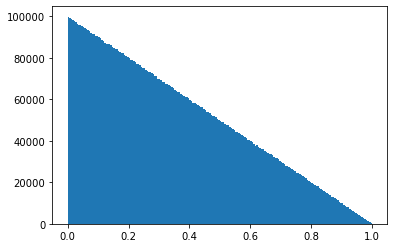

In [5]:
plt.hist(o, bins=200)

In [ ]:
p = measure_penultimate(2)